# 15-688 Practical Data Science, Tutorial Assignment 
#  Who will Die in the next season of GoT
![got_title](https://upload.wikimedia.org/wikipedia/en/d/d8/Game_of_Thrones_title_card.jpg)

## What is GoT?     
**Game of Thrones** (GoT) is an American fantasy drama television series created by David Benioff and D. B. Weiss. It is an adaptation of A Song of Ice and Fire, George R. R. Martin's series of fantasy novels, the first of which is A Game of Thrones. It is filmed in Belfast and elsewhere in the United Kingdom, Canada, Croatia, Iceland, Malta, Morocco, Spain, and the United States. The series premiered on HBO in the United States on April 17, 2011, and its seventh season ended on August 27, 2017. The series will conclude with its eighth season premiering in 2019. ([site from Wikipedia](https://en.wikipedia.org/wiki/Game_of_Thrones))  

## Goal of the tutorial
Along with its exciting story, the numerous death of characters is also a characteristic of GoT series. This tutorial will predict which characters will die in the next season of GoT with some basic NLP techniques. 

## How to make the prediction?
The prediction of this tutorial is based on the assumption that people with **similar personality** will have great possibility to end up in a same way. Thus we will fetch the personality text from the [**Fandom Wiki**](http://gameofthrones.wikia.com/wiki/Game_of_Thrones_Wiki) page. Then we will do word embedding to each text transform them to vectors in a high dimensional space. For each living charactor we will compare his vector, representing his personality, with the vectors from those dead character. Being more similiar to the dead characters leads to a higher possibility to be dead in the next season. In the later part of the tutorial, I will introduce how to achieve that goal in detail.

## Library Preparation

Most of later work in the tutorial is based on NLP, thus we need liararies to fetch text from html as well as do word embedding.
1. [**Beatuiful Soup**](https://www.crummy.com/software/BeautifulSoup/bs4/doc/): A library used for fetching data from html.
2. [**nltk**](https://www.nltk.org/): A library used for natural language processing. In this tutorial, we will use it to do text tokenization and remove stop words from the text.
3. [**Gensim**](https://radimrehurek.com/gensim/): A library that realize unsupervised semantic modelling from plain text. In this tutorial, we will use it to do the word embedding to the plain text.
**[Note]** we will use pre-trained word2vec [model](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) provided by [google](https://code.google.com/archive/p/word2vec/). It is a 1.5Gb binary file. If you want to run the code, you will need to download the file and place it in the same directory as this notebook.
4. [**Scipy**](https://www.scipy.org/): A library used for scientific calculation in Python.
5. [**tqdm**](https://github.com/tqdm/tqdm): A python library used for monitoring loop progress.

Since we have already used Beautiful Soup, Scipy and nltk in the assignments, the installation will just be omitted. For Gensim and tqdm library you can just install it with pip.

```
pip install --upgrade gensim
pip install tqdm
```





In [1]:
from bs4 import BeautifulSoup
import requests
import gensim
import nltk
import string
import scipy
from nltk.corpus import stopwords
from tqdm import tqdm

# Fetching data from html

After importing the libraries, we now need to fetch character information from the [**Fandom Wiki**](http://gameofthrones.wikia.com/wiki/Game_of_Thrones_Wiki) page. First we need to locate the infomation we need on the wiki page. Here is two sample screen shots of the character wiki.

   | ![jon](wiki_sample1.png) | ![tywen](wiki_sample2.png) |
   |--------------------------|----------------------------|

We can find out that both of the wiki page contain the same structure (as highlighted):
1. A url start with "http://gameofthrones.wikia.com/wiki/" followed by the full name of the character.
2. A block of text describing the personality of the character.
3. A table that contain the live or dead status of the character.


Then we can inspect the html of the page and use Beautiful Soup to get the text we need.
![sta_sample](status_sample.png)


The highlighted html code is the part for the living status of the character.

![psn_sample](personality_sample.png)


For personality text we can find out that it is composed by multiple html pharagraph elements, we will append those element into a single python string.

Now we can implement our web pharser function to get the data and store them as a python dictionary.


In [2]:
def get_wiki_info(ch_list):
    """
    This function fetchs character's personality text and living status from Fandom Wiki; returns a python
    dictionary for the data as well as a list of names of dead characters.
    
    Args: 
        ch_list: a list of names from GoT series.
        
    Returns: tuple:(data, dead_list)
        data: a python dictionary of dictionary. Using characters' names as key. For each entry, also a 
                dictionary, having 'personality', 'status' and 'name' as attributes.
        dead_list: a list of strings representing the names of dead characters.
    """
    data = {}
    dead_list = []
    #use tqdm to monitor the loop
    for ch in tqdm(ch_list):
        #get the corresponding Wiki page
        url = 'http://gameofthrones.wikia.com/wiki/'+ch
        res = requests.get(url)
        root = BeautifulSoup(res.content,"html.parser")
        #get the personnality text of the character
        temp = root.find(id='Personality')
        #if the character does not have a personality text just ignore him/her.
        if temp == None:
            continue
        text = ''  
        temp = temp.parent.findNextSibling()
        text += temp.text
        while True:
            temp = temp.findNextSibling()
            #fetch all text until a non <p> tag.(which means parser has reached the next section)
            if (temp == None) or (temp.name != 'p'):
                break
            text += temp.text
        #get the status of the character
        status = root.find(text='Status')
        #if the character does not have a status text just ignore him/her
        if status == None:
            continue
        status = status.parent.findNextSibling('div')
        if status == None:
            continue
        status = status.text
        #if the character is not alive, add him/her into dead_list
        if 'live' not in status:
            dead_list.append(ch)
        d = {}
        d['name'] = ch
        d['personality'] = text
        d['status'] = status
        data[ch] = d
    return data, dead_list

# load in character list
def load_ch_list(fname):
    """
    This function will take in string as the path of a file that contains the list of character names.
    
    Args:
        fname: a string representing the path to the name list file.
    
    Return:
        ch_list: a list of strings, each representing the name of a character
    """
    ch_list = []
    file = open(fname, 'r')
    for ch in file:  
        ch_list.append(ch.replace('\n',''))
    file.close()
    return ch_list


For convenience, I have listed all names from the series and stored them in the file called "characters.txt". We only need to call the previous funtions to fetch all the data we need. (it might take couple minutes to run the code)

In [3]:
ch_list = load_ch_list('characters.txt')
data, dead_list = get_wiki_info(ch_list)

100%|██████████| 905/905 [04:05<00:00,  3.69it/s]


Now we can peek the data we have collected. I successfully get 78 characters' status and personality texts from the wiki page. The following code the shows the data for the sample character "Jon Snow".

In [4]:
print('total num of characters:', len(data))
#sample data point 
char = 'Jon_Snow'
for key in data[char].keys():
    print(key, data[char][key])

total num of characters: 78
name Jon_Snow
personality 
"You are a Stark. You may not have my name, but you have my blood."
―Eddard Stark to Jon before he leaves for the Night's Watch.[src]Because he was raised by Ned Stark at Winterfell, Jon has adopted a clear moral compass and a true sense of honor, which he tries his hardest to abide by even when he must make a difficult decision, especially after he became Lord Commander of the Night's Watch. He has always admired and idolized his father, but due to Catelyn Stark's cold disdain for Jon, Eddard was careful not to give him more attention than his lawful children by Catelyn. Lady Stark was never actively mean to Jon, but because he wasn't her own son she intentionally ignored him (as is common for bastard children), meaning that Jon grew up without a mother-figure. Nor did Jon consider Catelyn's behavior to be unusual or unexpected: it is rare for a noble to raise their bastard child alongside their lawful children, and his presence w

# Text processing 
Already getting all the raw data, we then need to process the personality text to run a similarity calculation. This includes two steps, Tokenization and Word Embedding.

## Tokenization

The goal we need to achieve in this part is to transform a text string into a list of tokens (single words) and remove the stopwords (like "the", "is", "are"). Similiar to our previous assignment, we will first remove the punctuation from the text and use nltk library to do the tokenization and stopwords removing.

In [5]:
def tokenization(text):
    """
    This function takes a a string of text. Then tokenize it.
    
    Args:
        text: a text string
    Returns:
        a list of tokens(words)
    """
    stpwords = stopwords.words('english')
    text = text.lower()
    proc = ''
    i = 0
    while i < len(text):
        c = text[i]
        #remove punctuation
        if c not in string.punctuation:
            proc+=c
        elif c == "'":
            if i == (len(text)-1):
                break
            if text[i+1] == 's' and (i+2) == len(text):
                break
            if text[i+1] == 's' and text[i+2] == ' ':
                i+=1
        else:
            proc+=' '
        i+=1  
    #tokenization by nltk
    tokens = nltk.word_tokenize(proc)
    #remove stop words in tokens
    result = []
    for word in tokens:
        if word not in stpwords:
            result.append(word)
    return result

In [6]:
#tokenize the personality text of each character
for name in data.keys():
    tokens = tokenization(data[name]['personality'])
    data[name]['tokens'] = tokens

Now our data dictionary get a new column call 'tokens' which is the tokenized personnality text. Here is the sample tokens for character "Jon Snow"

In [7]:
print(len(data[char]['tokens']))
print(data[char]['tokens'])

464
['stark', 'may', 'name', 'blood', '―eddard', 'stark', 'jon', 'leaves', 'night', 'watch', 'src', 'raised', 'ned', 'stark', 'winterfell', 'jon', 'adopted', 'clear', 'moral', 'compass', 'true', 'sense', 'honor', 'tries', 'hardest', 'abide', 'even', 'must', 'make', 'difficult', 'decision', 'especially', 'became', 'lord', 'commander', 'night', 'watch', 'always', 'admired', 'idolized', 'father', 'due', 'catelyn', 'stark', 'cold', 'disdain', 'jon', 'eddard', 'careful', 'give', 'attention', 'lawful', 'children', 'catelyn', 'lady', 'stark', 'never', 'actively', 'mean', 'jon', 'wasnt', 'son', 'intentionally', 'ignored', 'common', 'bastard', 'children', 'meaning', 'jon', 'grew', 'without', 'mother', 'figure', 'jon', 'consider', 'catelyn', 'behavior', 'unusual', 'unexpected', 'rare', 'noble', 'raise', 'bastard', 'child', 'alongside', 'lawful', 'children', 'presence', 'great', 'insult', 'honor', 'interactions', 'catelyn', 'remained', 'awkward', 'nonexistent', 'actually', 'became', 'good', 'frie

## Word Embedding 

Now we can use those tokens to get vectors for the personality texts with word embedding techniques. We will get the vector for each token with [**word2vec**](https://code.google.com/archive/p/word2vec/), then we add them up to get the vector that representing the whole text. 

### pre-trained model
To get a model to do word embedding is a huge amount of workload. Thus, we will just use the [**pre-train model**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit) provided by google. (If you want to run the code, you need to **download it by yourself**. Putting it in the **same directory** as this notebook and name it as "**GoogleNews-vectors-negative300.bin**") It is a 1.5 Gb binary file loading it require a 64-bit machine and at least 4Gb memory. Here is a small sample showing how to load and use it with gensim. 

In [8]:
#load google word2vec model
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
# sample of using the model
w1 = 'heroic'
w2 = 'valiant'
#directly get the vector representaion of the word
x = model[w1]
y = model[w2]
#similarity calculation by gensim 
print(w1, w2, model.similarity(w1, w2))
#similarity calculation by scipy
print(1- scipy.spatial.distance.cosine(x,y))

heroic valiant 0.6859648230509401
0.685964822769165


In [10]:
def embedding(tokens, model):
    """
    This function takes a list of tokens(words), and a pretrained word2vec model in gensim.
        Then transform the tokens into a single vector.
    Args: 
        tokens: a list of string representing the tokens
        model: a pretrained word2vec gensim model
    returns:
        vec: a np array representing the tokens.
    """
    vec = None
    for word in tokens:
        #if the model does not contain the word. just skip it
        if word not in model.vocab:
            continue
        if type(vec) != type(None):
            vec = vec + model[word]
        else:
            vec = model[word]
    return vec

In [11]:
#getting personality vector for each character
for name in data.keys():
    data[name]['vec'] = embedding(data[name]['tokens'], model)

In [12]:
#sample personality vector for "Jon Snow"
print(type(data[char]['vec']))
print(data[char]['vec'])

<class 'numpy.ndarray'>
[ 23.165459    29.58895      5.9385414   33.114426   -18.410688
   5.4663544   11.406567   -36.634567    39.979927    29.939775
  17.070171   -62.735992   -10.708048    15.202353   -44.0137
  35.17154     18.52655     54.492424    -7.2010117  -14.7512245
  -5.4111686   12.598007    23.426144     8.016315    10.762899
 -47.51425    -35.41417     34.715725    18.759268   -12.267889
  10.610996    -2.1443381  -13.194986     8.172197     3.968193
  -5.5621147   29.354519     0.06894732   6.0522385   15.829994
  44.59671    -21.15451     49.114746   -17.739769     6.9366217
  -8.288228   -24.914143     4.660141    -8.577812   -10.728855
 -16.011852    20.972815    -8.598244    -4.2051773    0.66635084
   2.9211783  -34.421616   -27.888428    -2.934435   -26.126633
   0.44540977  46.49852    -26.19762    -24.48819    -15.018839
   2.2421265  -13.048817    22.312607   -25.035772    25.263132
  26.582825    12.373302     3.526081    24.202202   -54.247726
 -19.894016   

# Similarity Calculation

Since we have got all the elements we need, we can proceed to get the similarity between two characters by calculating the [**cosine similarity**](https://en.wikipedia.org/wiki/Cosine_similarity) of their personality vectors.

In [13]:
def get_similar_list(data):
    """
    This function takes in the preprocessed data dictionary and add a new column for each character
        called simi_list, representing the similarity between him/her with other characters.
        
    Args: 
        data: preprocessed python dictionary
    Returns
        data: same dictionary with an additional column in each entry.
    """
    for name in data.keys():
        x = data[name]['vec']
        s = []
        for key in data.keys():
            y = data[key]['vec']
            #append the name and similarity value to the list
            s.append((key, 1-scipy.spatial.distance.cosine(x,y)))
        #sort the list in desending order
        s.sort(key=lambda x: x[1], reverse = True)
        data[name]['simi_list'] = s[1:]
    return data


data = get_similar_list(data)

## Similarity Results

Having get all similarity values between each character, we can check result for some characters. The following table is made from the similarity value of Character Jon Snow.

### Jon Snow's Similarity
![Jon](https://vignette.wikia.nocookie.net/gameofthrones/images/a/a5/Profile-JonSnow-707.png/revision/latest?cb=20170828030553)

 |          Name          | Similarity Value    | Actual Relation with the character|
 | ---------------------- | ------------------- | --------------------------------------------------- |
 |  Sansa Stark | 0.953 | "Sister" of Jon, lived together since young  |
 |  Gendry |  0.936  |  Both are "bastard", brave and loyal |
 |  Samwell Tarly |  0.934  | Both are Nights' Watch, fight against white walkers |
 |  Cersei Lannister | 0.618 | Really have nothing in common|

We can see from the table that the similarity results are quite accurate according to our expectations. The following code plots the similarity value of five characters that are most similiar to Jon Snow.

Sansa_Stark 0.9529415965080261
Gendry 0.938775897026062
Jaime_Lannister 0.9355757832527161
Samwell_Tarly 0.934771716594696
Davos_Seaworth 0.9321074485778809


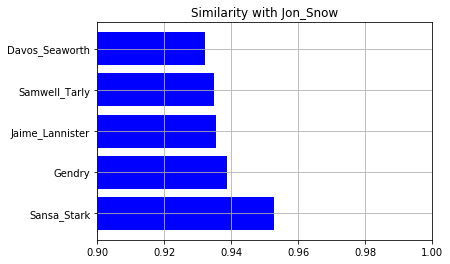

In [14]:
import matplotlib.pyplot as plt
char = 'Jon_Snow'
x = []
y = []
for i in range(5):
    x.append(data[char]['simi_list'][i][0])
    y.append(data[char]['simi_list'][i][1])
    print(x[i], y[i])
plt.barh(range(len(x)), y, color = 'b')
plt.yticks(range(len(x)),x)
plt.xlim(0.9, 1.0)
plt.title("Similarity with "+char)
plt.grid()
plt.show()

# Final prediction

Finally, we can use the similarity values to find out who is the most similiar to dead characters. We will get the mean value of a character's similarity to all dead characters. The higher the mean score gets, the more similar they are to dead characters and have a higher possiblity to be dead in the next season.

In [15]:
def get_similarity_to_deads(data, dead_list):
    """
    this function calculate the similarity value to dead characters and append the result
        to the original dictionary.
    Args:
        data: python dictionary. the processed data dict
        dead_list: a list of strings. representing the name of dead characters
    Returns:
        data: original data dict with additional column.
    
    """
    for name in data.keys():    
        data[name]['simi_to_dead'] = 0
        #skip the already dead characters
        if 'live' not in data[name]['status']:
            continue
        #get the similarity to deads
        for n, simi in data[name]['simi_list']:
            if n in dead_list:
                data[name]['simi_to_dead'] += simi
        data[name]['simi_to_dead'] /= len(dead_list)
    return data

data = get_similarity_to_deads(data, dead_list)

In [16]:

pos_dead_list = []
for key in data.keys():
    pos_dead_list.append((key, data[key]['simi_to_dead']))
pos_dead_list.sort(key=lambda x: x[1], reverse = True)


Jaime_Lannister 0.8917776025258578
Tyrion_Lannister 0.8815246912149283
Sandor_Clegane 0.8794907480478287
Davos_Seaworth 0.8787579914698234
Gendry 0.8759486812811631
Theon_Greyjoy 0.8738528593228414
Euron_Greyjoy 0.8730627871476687
Melisandre 0.8716663844310321
Ellaria_Sand 0.8696064731249442
Jorah_Mormont 0.868527447948089
Tormund 0.8660301875609618
Sansa_Stark 0.8655548302026895
Brienne_of_Tarth 0.8636855918627518
Qyburn 0.8631894152898055
Yara_Greyjoy 0.8609222551951041
Jon_Snow 0.85592554968137
Samwell_Tarly 0.8554722907451483
Arya_Stark 0.8530378164007113
Bran_Stark 0.8479280368639872
Robin_Arryn 0.838019569332783
Bronn 0.8313157226030643
Wolkan 0.8256011318701965
Ilyn_Payne 0.820197385091048
Daenerys_Targaryen 0.7615419162007478
Varys 0.6899138666116275
Cersei_Lannister 0.5695132876817997


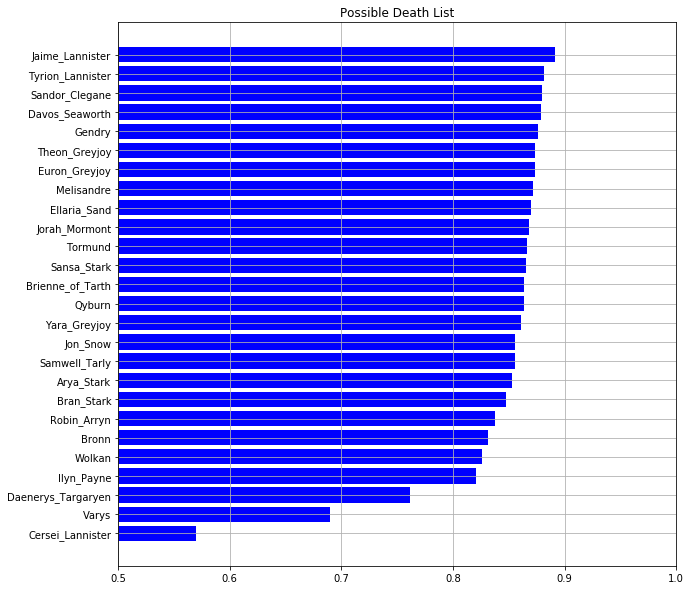

In [17]:
x = []
y = []
for i in pos_dead_list:
    if i[1] == 0:
        break
    x.append(i[0])
    y.append(i[1])
    print(i[0], i[1])
plt.figure(figsize=(10, 10))
plt.barh(range(len(x)), y, color = 'b')
plt.yticks(range(len(x)),x)
plt.xlim(0.5, 1.0)
plt.title("Possible Death List")
plt.gca().invert_yaxis()
plt.grid()
plt.show()

# Final Results
From the previous plot we can get our predction results:
## The most possible character to be Dead: Jaime Lannister
![Jaime](https://vignette.wikia.nocookie.net/gameofthrones/images/e/eb/Jaime.jpg/revision/latest/scale-to-width-down/296?cb=20170818052054)


## The least possible character to be Dead: Cersei Lannister
![Cersei](https://vignette.wikia.nocookie.net/gameofthrones/images/c/c3/Profile-CerseiLannister.png/revision/latest/scale-to-width-down/323?cb=20170828071355)



# Summary and Reference
The result is a kind of prediction by my naive assumption. After all, it's not strange for any character to be dead in GoT. The main goal of this tutorial is learn a complete process from information fetching and processing, to word embedding and similarity calculation. Thanks for [Fandom](http://fandom.wikia.com/) for providing such a great wiki page for fans like me. For further details of the libraries used, please refer to their offical document.

1. [**Fandom Wiki**]: http://fandom.wikia.com/
2. [**Beatuiful Soup**]: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
2. [**nltk**]: https://www.nltk.org/
3. [**Gensim**]: https://radimrehurek.com/gensim/
4. [**Google word2vec project**]: https://code.google.com/archive/p/word2vec/
5. [**Scipy**]: https://www.scipy.org/
6. [**tqdm**]: https://github.com/tqdm/tqdm